## Implementing backpropagation on tensors from scratch.

**References**

[1] [Building makemore Part 4: Becoming a Backprop Ninja](https://www.youtube.com/watch?v=q8SA3rM6ckI&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=6&ab_channel=AndrejKarpathy)

[2] [Yes you should understand backprop](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b)

**Exercises**

0. *Read the arcticle [2] and write down why do we need to understand backpropagation.*
1. *Backprop through the whole thing manually, backpropagating through exactly all of the variables as they are defined in the forward pass above, one by one*
2. *backprop through cross_entropy but all in one go, to complete this challenge look at the mathematical expression of the loss, take the derivative, simplify the expression, and just write it out*
3. *Visualiaze the derivative of logits for a random forward pass, for a good forward pass (where we get lets say 70 % of predictions right) and for a perfect forward pass, what is happening with the derivative of logits and why ?*
4. *backprop through batchnorm but all in one go, to complete this challenge look at the mathematical expression of the output of batchnorm,+take the derivative w.r.t. its input, simplify the expression, and just write it out, BatchNorm paper: https://arxiv.org/abs/1502.03167*
5. *putting it all together! Train the MLP neural net with your own backward pass*

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2022-12-03 10:02:06--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2022-12-03 10:02:07 (11.0 MB/s) - ‘names.txt’ saved [228145/228145]



In [76]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [77]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [78]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


**Utility function we will use later when comparing manual gradients to PyTorch gradients**

In [79]:
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

**Init network**

Note: I am initializating many of these parameters in non-standard ways
because sometimes initializating with e.g. all zeros could mask an incorrect
implementation of the backward pass.

In [80]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1

# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


## 0. *Read the arcticle [2] and write down why do we need to understand backpropagation.*

**Comment**: 


1. Bad initialization of network weights could lead into saturation of sigmoid and tanh activation functions and consequentely into vanashing gradients.
2. When using the sigmoid activation function the largest gradient we can get is $0.25$, meaning that every time the gradients signal flows through the sigmoid gate, its magnitude always diminishes by one quarter (or more).
3. Dead neurons in the ReLU activation function, i.e if a neuron is initialized in the zero regim of the ReLU function than its weights will get zero gradients. Such neuron would never fire, therefore its gradients will always be zero and it will never learn (dead neuron).


## 1. *Backprop through the whole thing manually, backpropagating through exactly all of the variables as they are defined in the forward pass above, one by one*

**Forward pass**

In [81]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [82]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact) # hidden layer

# Linear layer 2
logits = h @ W2 + b2 # output layer

# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3517, grad_fn=<NegBackward0>)

**Backpropagation**

Note, if broad casting along dimension $i$ happens in forward pass, than we have to perform the sumation in dimension $i$ in the backwardpass. Likewise if the sumation happens in the $i$th dimension of the tensor (during forward pass), than the broadcasting will have to happen along the $i$th dimension in the backward pass.


Note that during the forward pass (`loss = -logprobs[range(n), Yb].mean()`) we take only the values of logprobs that correspond to indicies defined in Yb, therefore the derivative of loss w.r.t logprobs is non zero only at location of Yb. Also note that the dimension of `dlogprob` has to match the dimension of `logprobs`, since `dlogprob` is used to update the `logprob` (update step of gradient descent). 

In [83]:
dloss = 1.0
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -(1 / n)
dlogprobs *= dloss

In [84]:
dlogprobs.shape, logprobs.shape

(torch.Size([32, 27]), torch.Size([32, 27]))

In [85]:
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


`logprobs = probs.log()`


In [86]:
dprobs = 1 / probs * dlogprobs

In [87]:
dprobs.shape, probs.shape

(torch.Size([32, 27]), torch.Size([32, 27]))

In [88]:
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


Note that in the forwardpass `probs = counts * counts_sum_inv` we get broadcasting (i.e counts_sum_inv gets broadcasted along the 1th dimension, i.e along columns), therefore we have to sum up the gradient along the 1th dimension during the backward pass.

In [89]:
dcounts_sum_inv = (counts * dprobs).sum(1, keepdims=True)

In [90]:
dcounts_sum_inv.shape, counts_sum_inv.shape

(torch.Size([32, 1]), torch.Size([32, 1]))

In [91]:
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


`counts_sum_inv = counts_sum**-1`

In [92]:
dcounts_sum = (-1 * counts_sum ** (-2)) * dcounts_sum_inv

In [93]:
dcounts_sum.shape, counts_sum.shape

(torch.Size([32, 1]), torch.Size([32, 1]))

In [94]:
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


Note that in this counts appears in two equations therefore taking the partial derivative of loss w.r.t to counts is defined as follows bellow.


Also note that in the forward pass we to the sum along the 1th dimension of counts therefore broadcasting along 1th dimension should take place.
Forward pass:
``` 
counts_sum = counts.sum(1, keepdims=True)
probs = counts * counts_sum_inv
```





In [95]:
dcounts = (torch.ones_like(counts)) * dcounts_sum + (counts_sum_inv) * dprobs

In [96]:
dcounts.shape, counts.shape

(torch.Size([32, 27]), torch.Size([32, 27]))

In [97]:
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


`counts = norm_logits.exp()`


In [98]:
dnorm_logits = norm_logits.exp() * dcounts

In [99]:
dnorm_logits.shape, norm_logits.shape

(torch.Size([32, 27]), torch.Size([32, 27]))

In [100]:
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


Note that in the forward pass (`norm_logits = logits - logit_maxes`), we get broadcasting along the 1th dim, therefore we should compute the sum along 1th dim in the backward pass.

In [101]:
dlogit_maxes = (-1.0 * dnorm_logits).sum(1, keepdim=True)

In [102]:
dlogit_maxes.shape, logit_maxes.shape

(torch.Size([32, 1]), torch.Size([32, 1]))

In [103]:
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


Forward pass:

```
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
```

Again we see that logits appears in two equations therefore taking the partial derivative of loss w.r.t logits requires us to perform two partial derivatives
logit_makes w.r.t logits and norm_logits w.r.t logits. Also note that here we perform the max operation along the 1th dimension therefore we have to perform broadcasting along the 1th dimension in the backwardpass.



In [116]:
temp = torch.zeros_like(logits)
temp[range(n), logits.max(1, keepdim=True).indices.view(-1, n)] = 1
dlogits = (norm_logits.exp()) * dcounts + (temp * dlogit_maxes)

In [117]:
dlogits.shape, logits.shape

(torch.Size([32, 27]), torch.Size([32, 27]))

In [118]:
cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


This time we are backpropagation through the linear layer, lets derive the formula on a simplified example. 

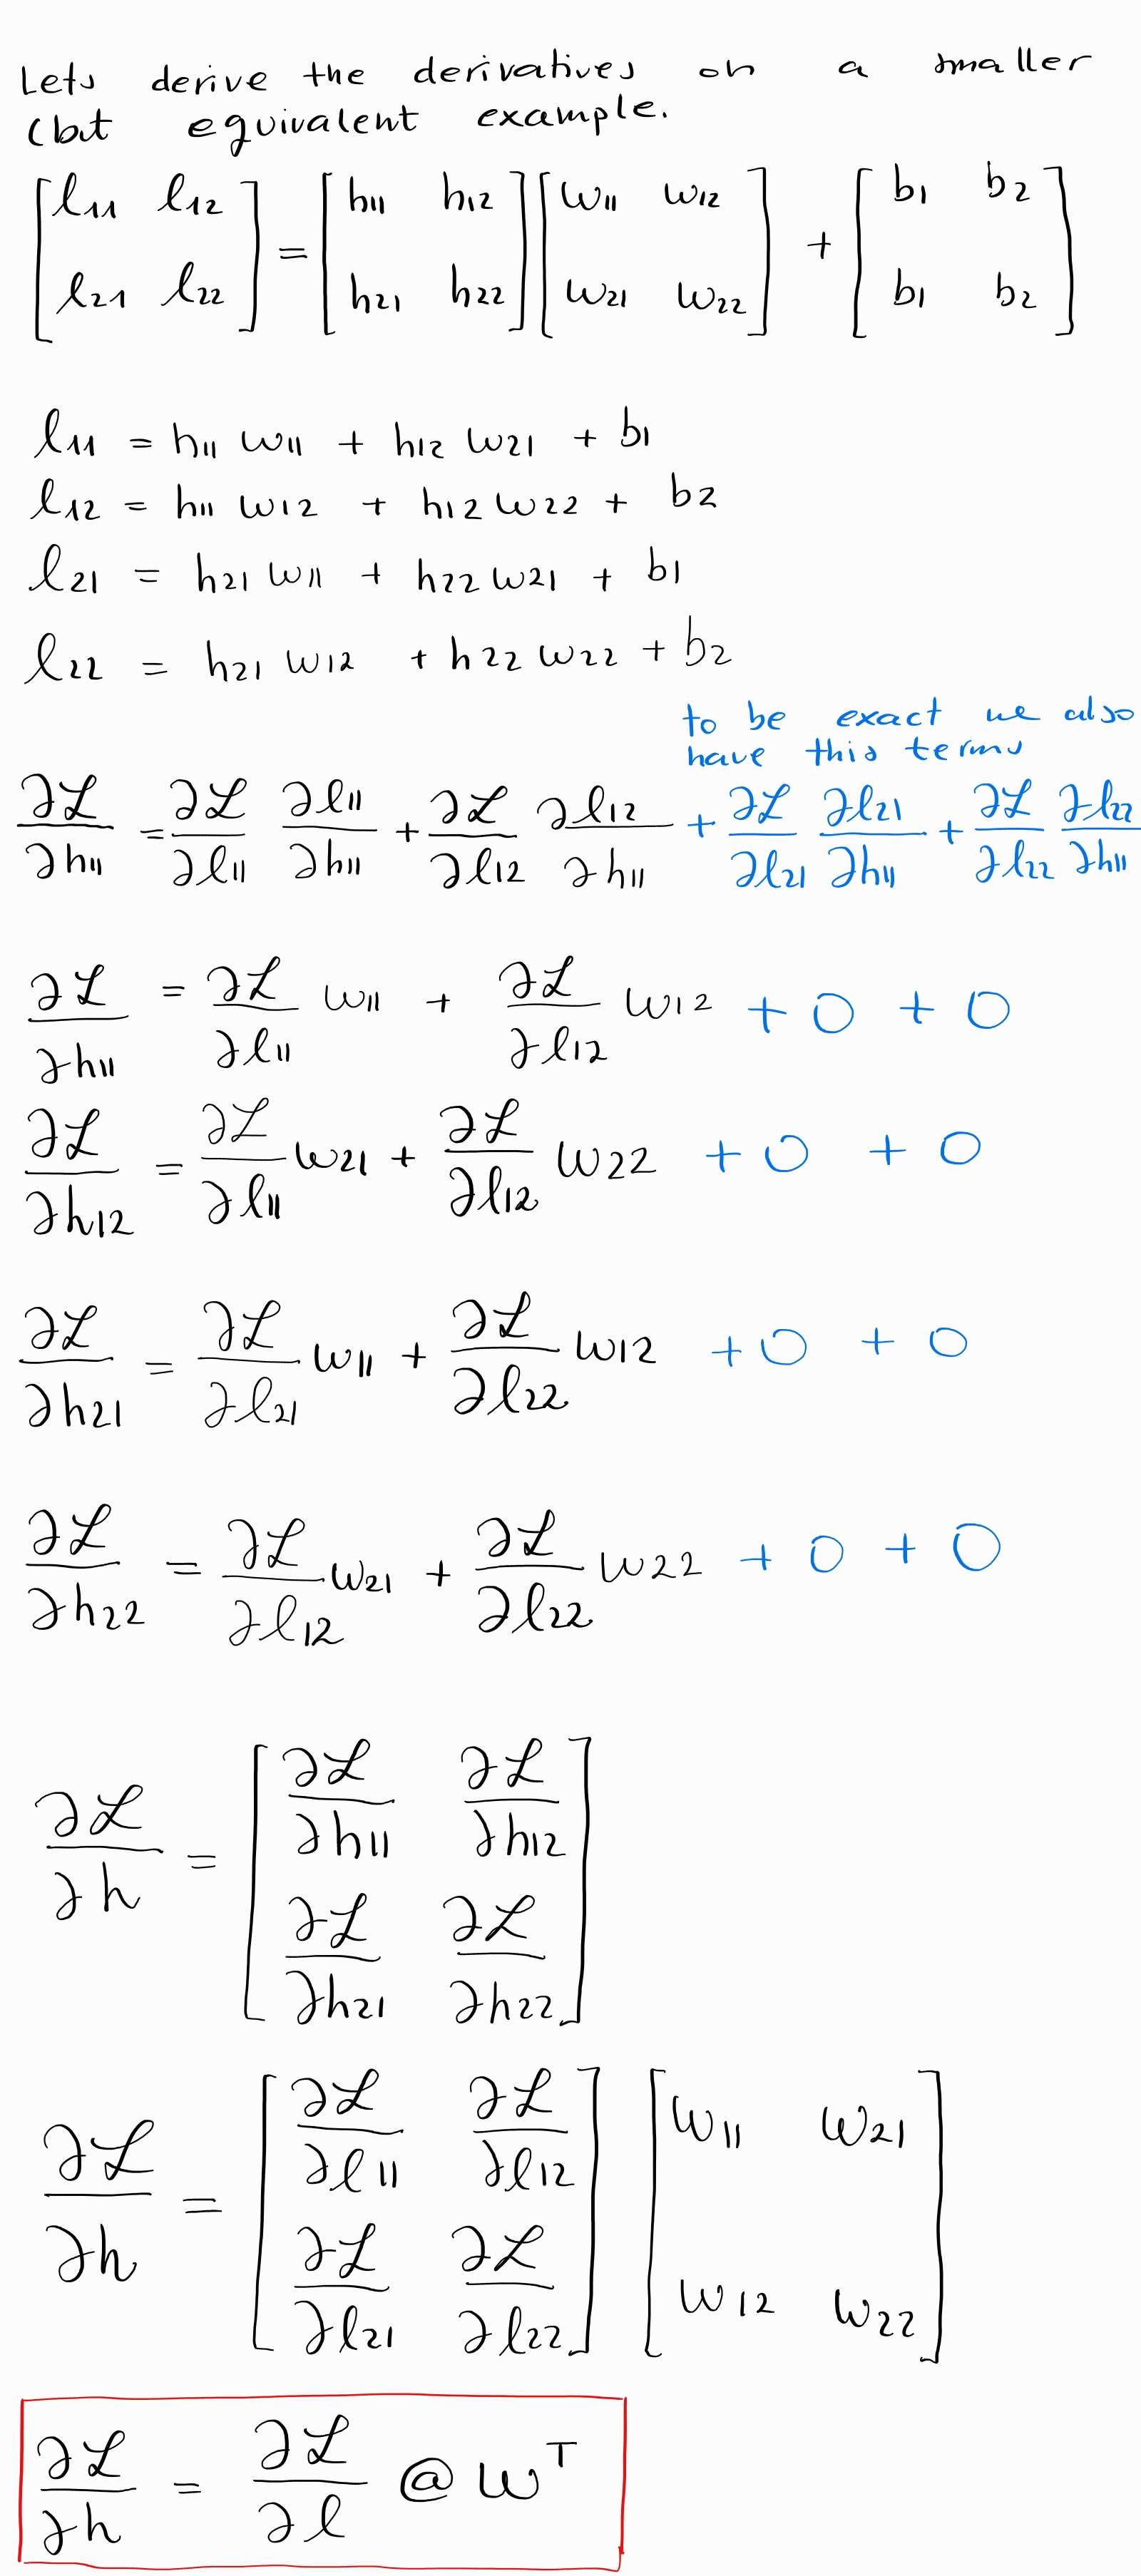

Forward pass:

`logits = h @ W2 + b2`

In [119]:
dh = dlogits @ W2.T

In [120]:
dh.shape, h.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [121]:
cmp('h', dh, h)

h               | exact: True  | approximate: True  | maxdiff: 0.0


Lets derive the partial derivative of the linear layer w.r.t weight matrix W2.

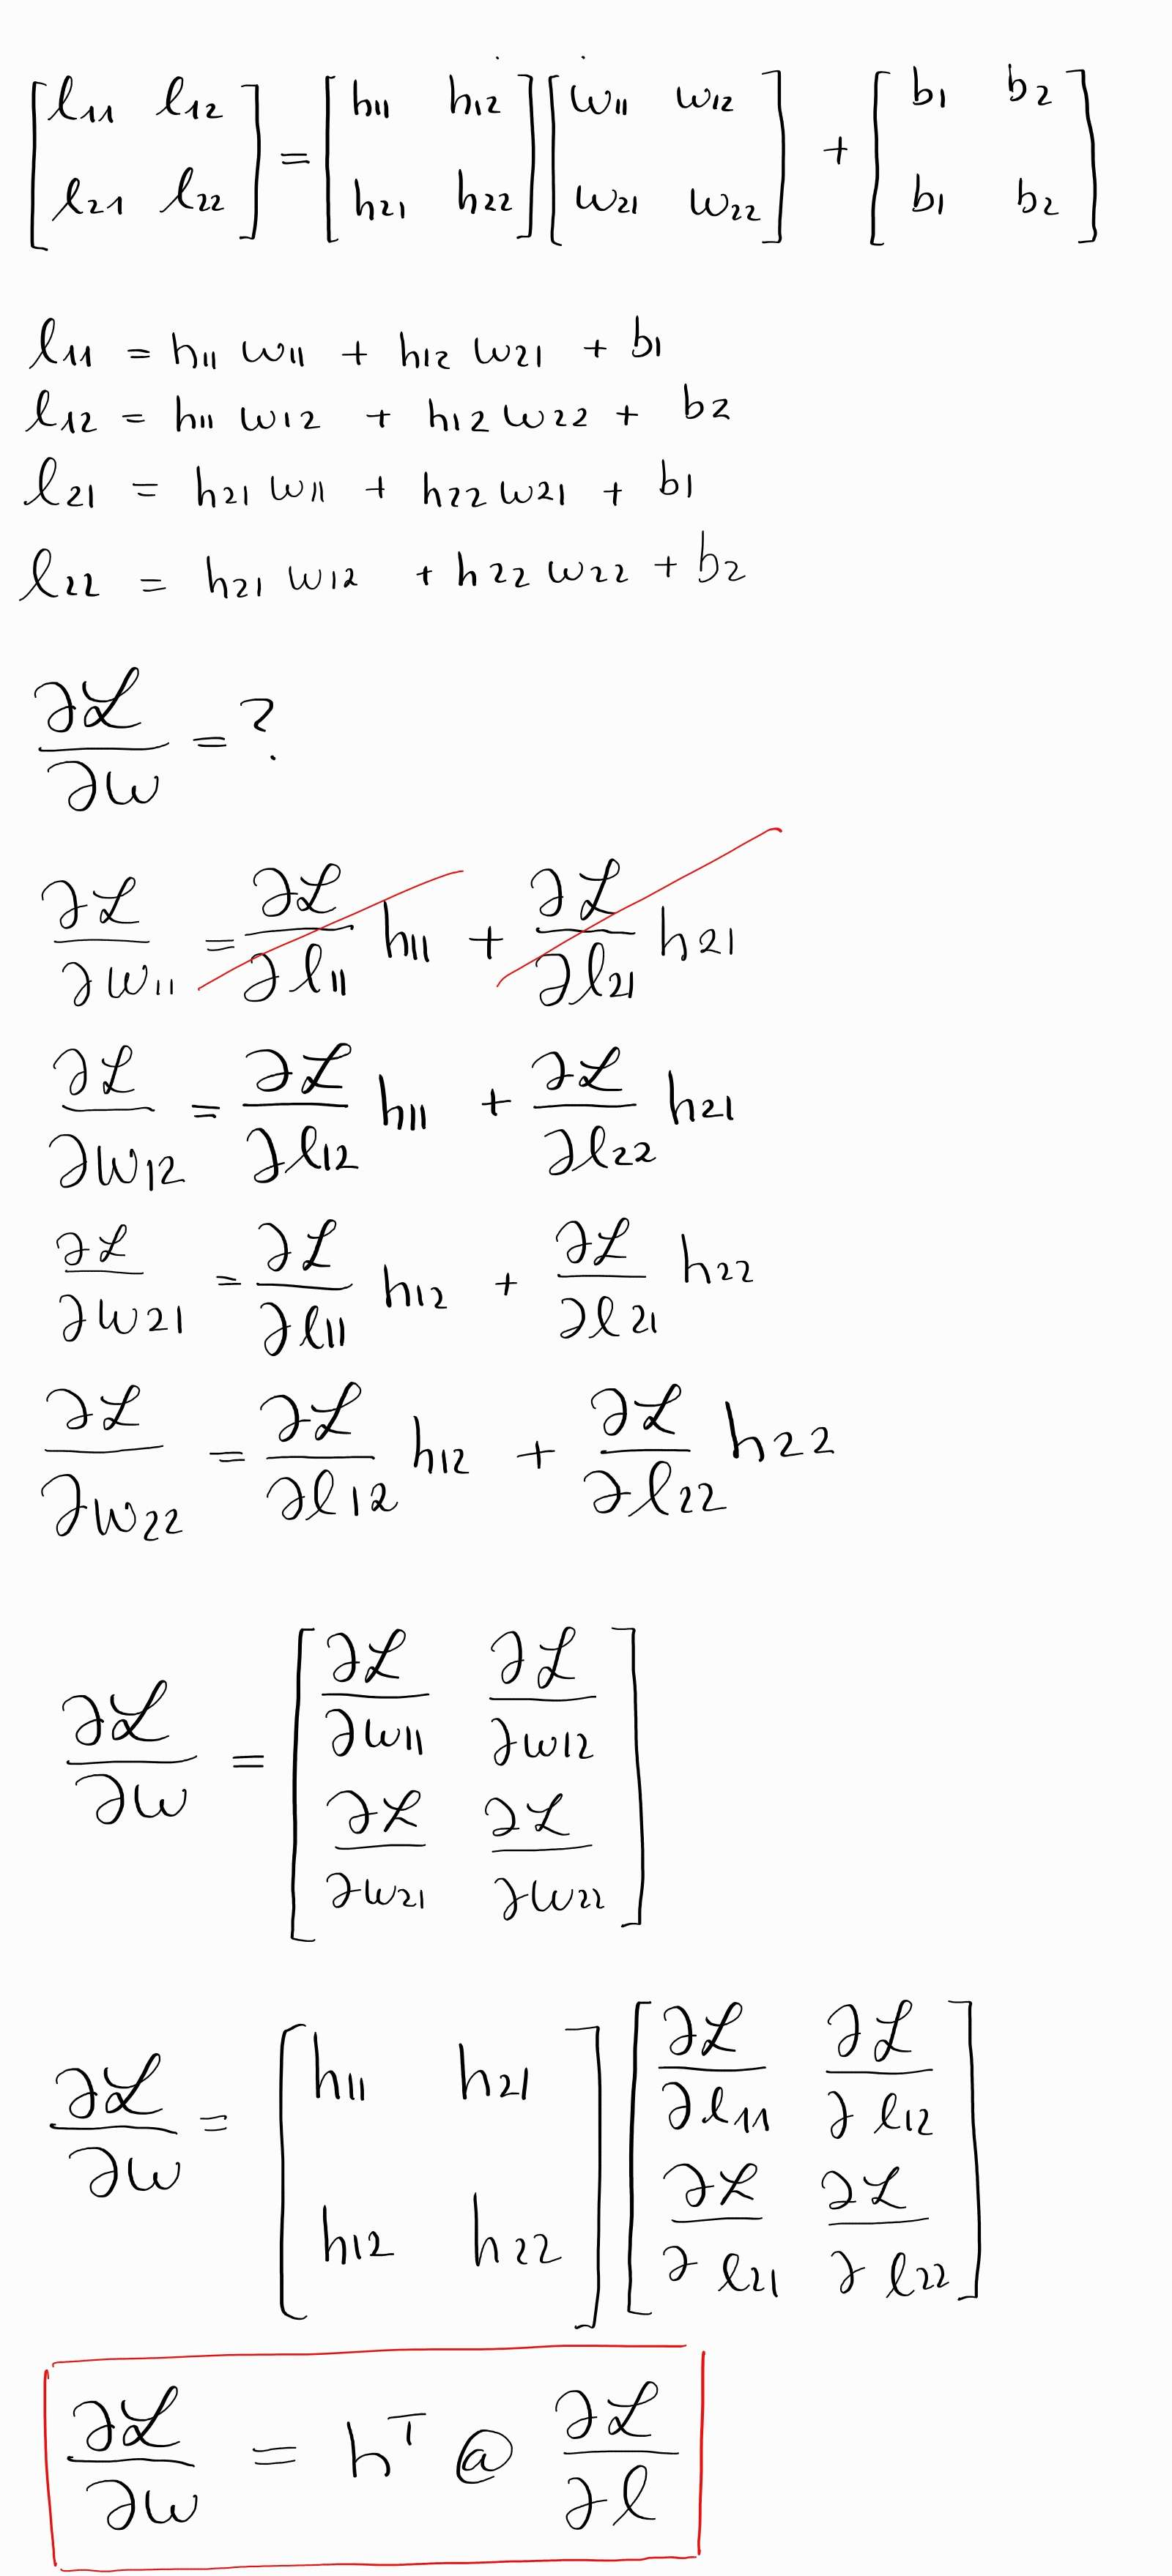

Forward pass:

`logits = h @ W2 + b2`

In [122]:
dW2 = h.T @ dlogits

In [123]:
dW2.shape, W2.shape

(torch.Size([64, 27]), torch.Size([64, 27]))

In [124]:
cmp('W2', dW2, W2)

W2              | exact: True  | approximate: True  | maxdiff: 0.0


Lets derive the partial derivative of the liner layer with respect to the bias term

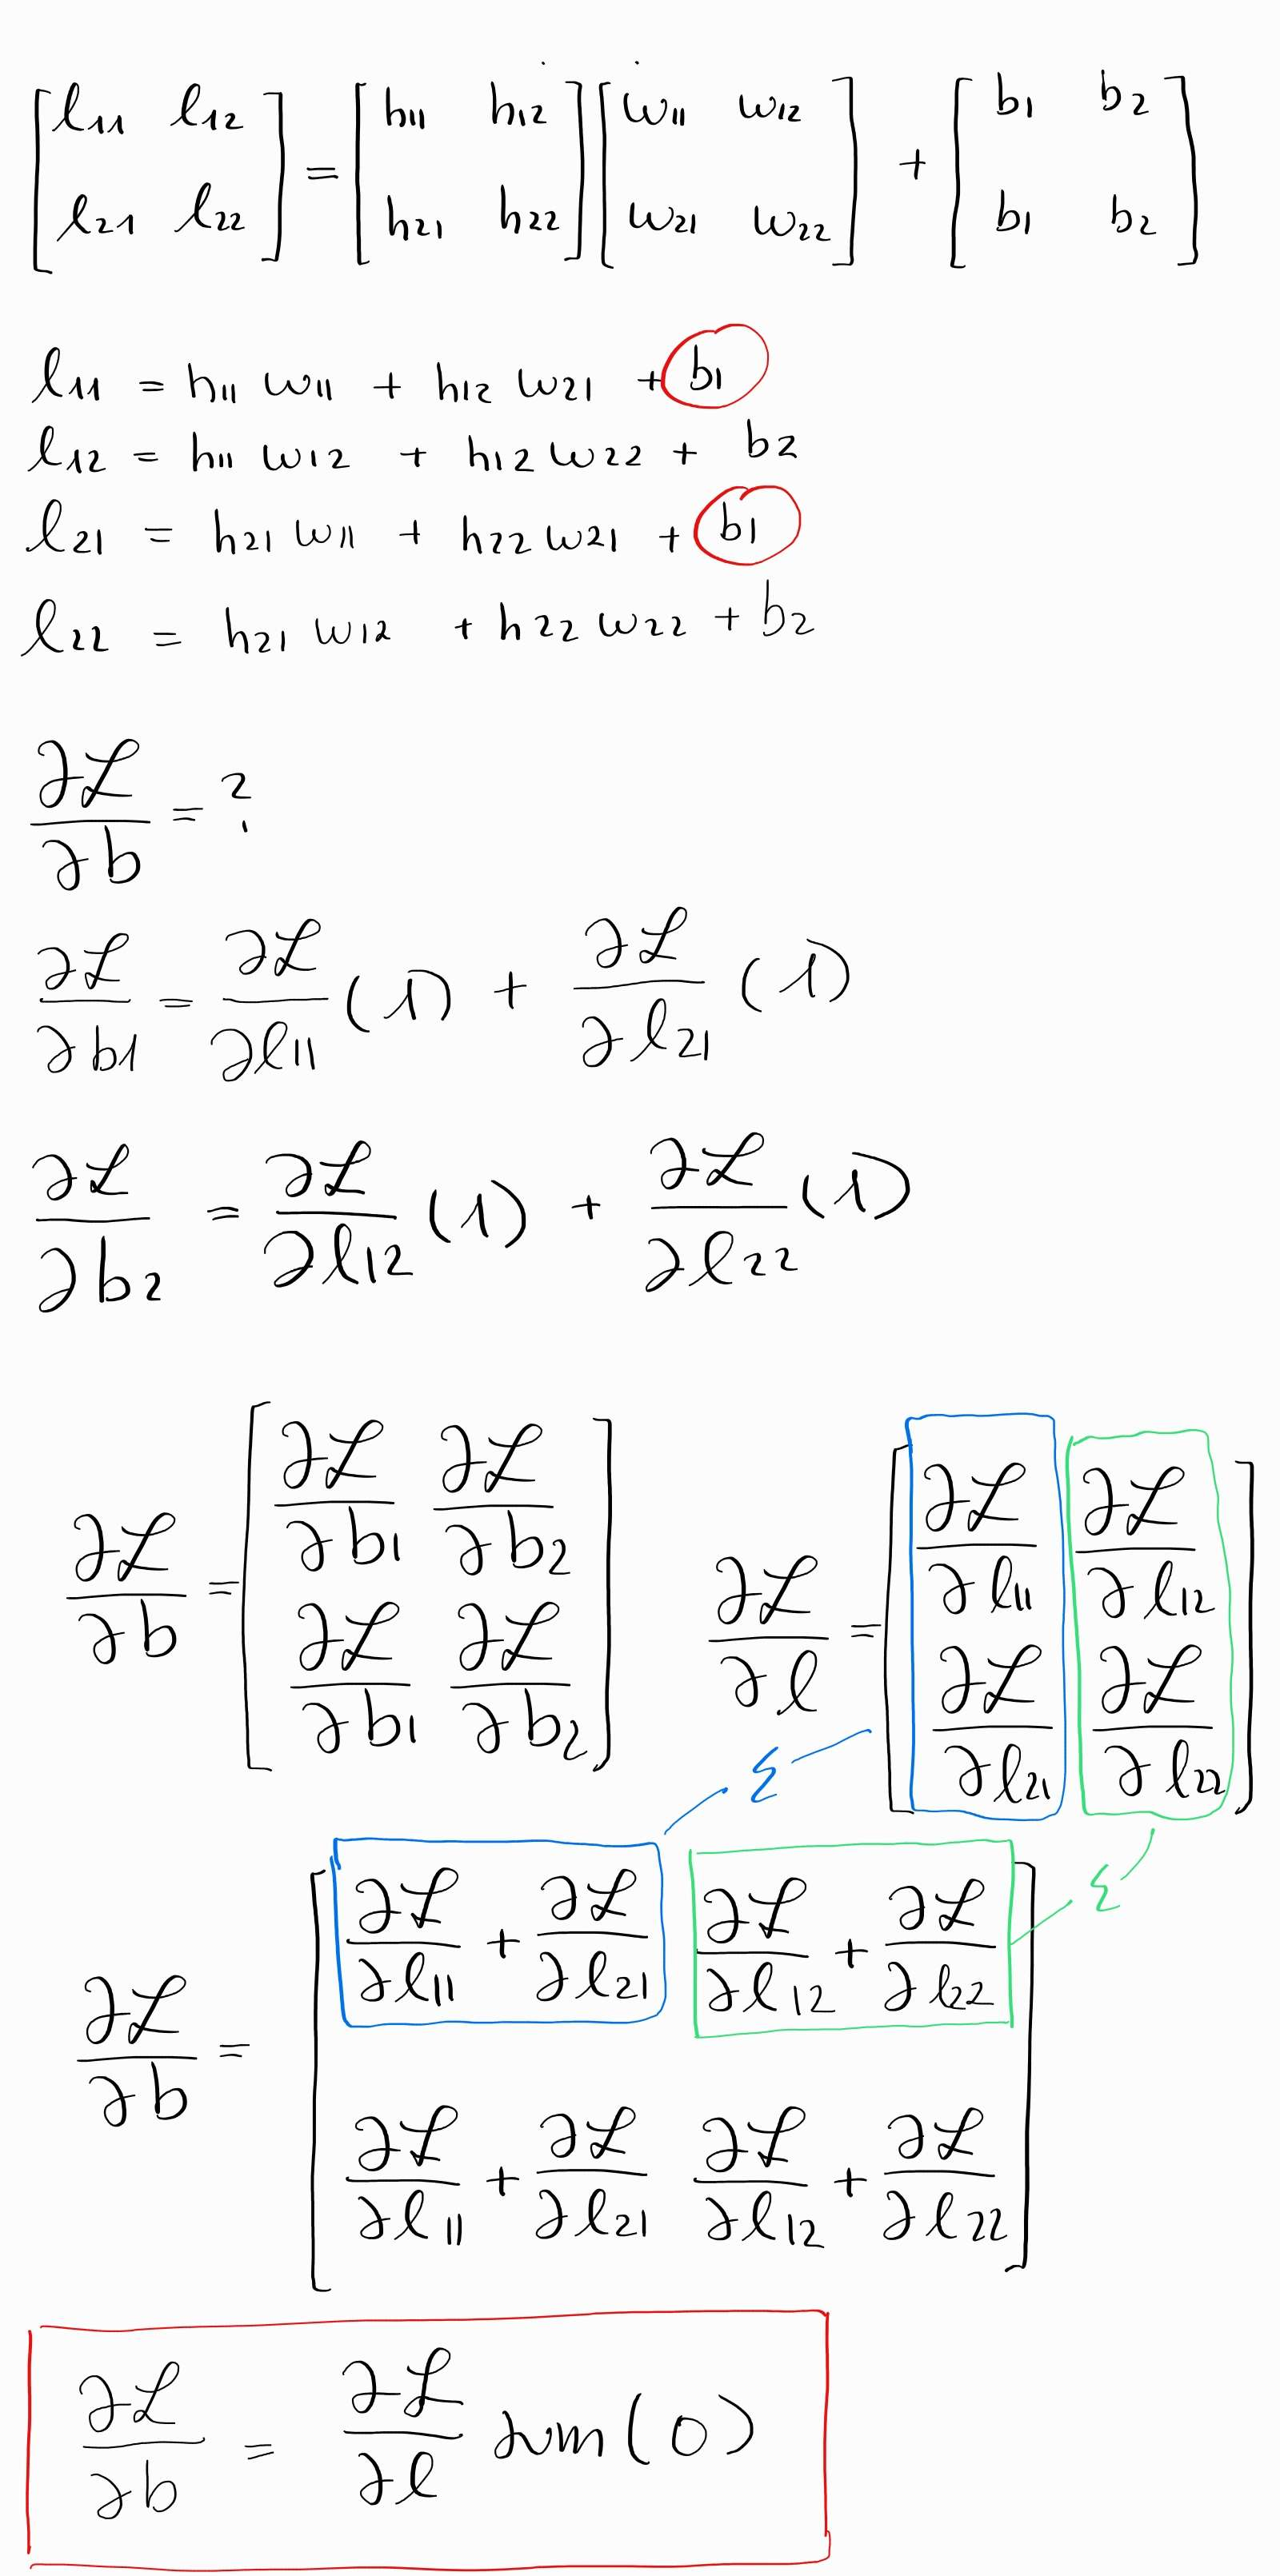

Forward pass:

`logits = h @ W2 + b2`

In [125]:
db2 = dlogits.sum(0, keepdim=True)

In [126]:
db2.shape, b2.shape

(torch.Size([1, 27]), torch.Size([27]))

In [127]:
cmp('b2', db2, b2)

b2              | exact: True  | approximate: True  | maxdiff: 0.0


Forward pass

`h = torch.tanh(hpreact)`

In [129]:
dhpreact = (1.0 - h**2) * dh

In [130]:
dhpreact.shape, hpreact.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [131]:
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


Forward pass

`hpreact = bngain * bnraw + bnbias`

Note that in the forward pass broadcasting along the 0th dimension, takes place therfore we should sum up the derivatives along the 0th axis during the backpropagaion.

In [134]:
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)

In [133]:
dbngain.shape, bngain.shape

(torch.Size([32, 64]), torch.Size([1, 64]))

In [135]:
cmp('bngain', dbngain, bngain)

bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09


Forward pass

`hpreact = bngain * bnraw + bnbias`


In [136]:
dbnraw = bngain * dhpreact

In [137]:
dbnraw.shape, bnraw.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [138]:
cmp('bnraw', dbnraw, bnraw)

bnraw           | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


Forward pass

`hpreact = bngain * bnraw + bnbias`

Note that during the forward pass broadcasting along the 0th dimension (of tensor bnbias) takes place, therefore we should sum up the gradients along the 0th dimension in the backward pass.

In [141]:
dbnbias = ((1) * dhpreact).sum(0, keepdim=True)

In [142]:
dbnbias.shape, bnbias.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

In [143]:
cmp('bnbias', dbnbias, bnbias)

bnbias          | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09


Forward pass:

`bnraw = bndiff * bnvar_inv`

Again bndiff is broadcasted along the 0th dim, therefore we should sum up the gradients along the 0th dimension.

In [146]:
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

In [147]:
dbnvar_inv.shape, bnvar_inv.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

In [148]:
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

bnvar_inv       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


Forward pass:

`bnvar_inv = (bnvar + 1e-5)**-0.5`

In [149]:
dbnvar = -0.5 * (bnvar + 1e-5) ** (-1.5) * (1) * dbnvar_inv

In [150]:
dbnvar.shape, bnvar.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

In [151]:
cmp('bnvar', dbnvar, bnvar)

bnvar           | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


Forward pass:

`bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)`

In [161]:
dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar

In [162]:
dbndiff2.shape, bndiff2.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

Forward pass:

```
bnraw = bndiff * bnvar_inv
bndiff2 = bndiff**2
```

Note that bndiff appears in two equations therefore we should take both into account when computing the gradient.

In [170]:
dbndiff = bnvar_inv * dbnraw + 2 * bndiff * dbndiff2

In [171]:
dbndiff.shape, bndiff.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [172]:
cmp('bndiff', dbndiff, bndiff)

bndiff          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


Forward pass

`bndiff = hprebn - bnmeani`

From here on we'll write the notes only if something new accures.

In [178]:
dbnmeani = (-1.0 * dbndiff).sum(0, keepdims=True)

In [179]:
dbnmeani.shape, bnmeani.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

In [180]:
cmp('bnmeani', dbnmeani, bnmeani)

bnmeani         | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


Forward pass:

```
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
```

In [184]:
dhprebn = 1.0 * dbndiff + 1/ n * torch.ones_like(hprebn) * dbnmeani

In [185]:
dhprebn.shape, hprebn.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [186]:
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


Forward pass

`hprebn = embcat @ W1 + b1`

In [197]:
dembcat = dhprebn @ W1.T

In [198]:
dembcat.shape, embcat.shape

(torch.Size([32, 30]), torch.Size([32, 30]))

In [199]:
cmp('embcat', dembcat, embcat)

embcat          | exact: False | approximate: True  | maxdiff: 1.3969838619232178e-09


Forward pass

`hprebn = embcat @ W1 + b1`

In [200]:
dW1 = embcat.T @ dhprebn

In [201]:
dW1.shape, W1.shape 

(torch.Size([30, 64]), torch.Size([30, 64]))

In [202]:
cmp('W1', dW1, W1)

W1              | exact: False | approximate: True  | maxdiff: 9.313225746154785e-09


Forward pass

`hprebn = embcat @ W1 + b1`

In [206]:
db1 = dhprebn.sum(0, keepdims=True)

In [207]:
db1.shape, b1.shape

(torch.Size([1, 64]), torch.Size([64]))

In [208]:
cmp('b1', db1, b1)

b1              | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


Forward pass:

`embcat = emb.view(emb.shape[0], -1)`

During the forward pass we reshape the vector emb, therefore we should reshape it back to its original form in the backward pass.

In [212]:
demb = (1.0 * dembcat).view(emb.shape)

In [213]:
demb.shape, emb.shape

(torch.Size([32, 3, 10]), torch.Size([32, 3, 10]))

In [214]:
cmp('emb', demb, emb)

emb             | exact: False | approximate: True  | maxdiff: 1.3969838619232178e-09


Forward pass

`emb = C[Xb]`



In [218]:
print(Xb[0])
print(Xb.shape)

tensor([1, 1, 4])
torch.Size([32, 3])


In [222]:
C[Xb].shape

torch.Size([32, 3, 10])

In [223]:
dC = torch.zeros_like(C)

In [224]:
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        idx = Xb[k, j]
        dC[idx] += demb[k, j]

In [225]:
dC.shape, C.shape

(torch.Size([27, 10]), torch.Size([27, 10]))

In [226]:
cmp('C', dC, C)

C               | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


**Lets put the indivudal gradients together**

In [227]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = (-1 / n) * 1.0
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = ((counts) * dprobs).sum(1, keepdim=True)
dcounts_sum = (-1 * counts_sum ** (-2)) * dcounts_sum_inv
dcounts = (counts_sum_inv * dprobs) + torch.ones_like(counts) * dcounts_sum
dnorm_logits = (norm_logits.exp()) * dcounts
dlogit_maxes = ((-1) * dnorm_logits).sum(1, keepdim=True)
temp = torch.zeros_like(logits)
temp[range(n), logits.max(1, keepdim=True).indices.view(-1, n)] = 1
dlogits = (norm_logits.exp()) * dcounts + (temp * dlogit_maxes)
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 =  dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdims=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdims=True)
dbnvar = (-0.5 * (bnvar + 1e-5) ** (-1.5)) * dbnvar_inv
dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) *  dbnvar
dbndiff = bnvar_inv * dbnraw + (2 * bndiff) * dbndiff2
dbnmeani = (-1 * dbndiff).sum(0, keepdim=True)
dhprebn = dbndiff.clone() + (1/n) * torch.ones_like(hprebn) *  dbnmeani
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0, keepdim=True)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        idx = Xb[k, j]
        dC[idx] += demb[k, j]

In [228]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnraw           | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
bnbias  

## 2. *backprop through cross_entropy but all in one go, to complete this challenge look at the mathematical expression of the loss, take the derivative, simplify the expression, and just write it out*

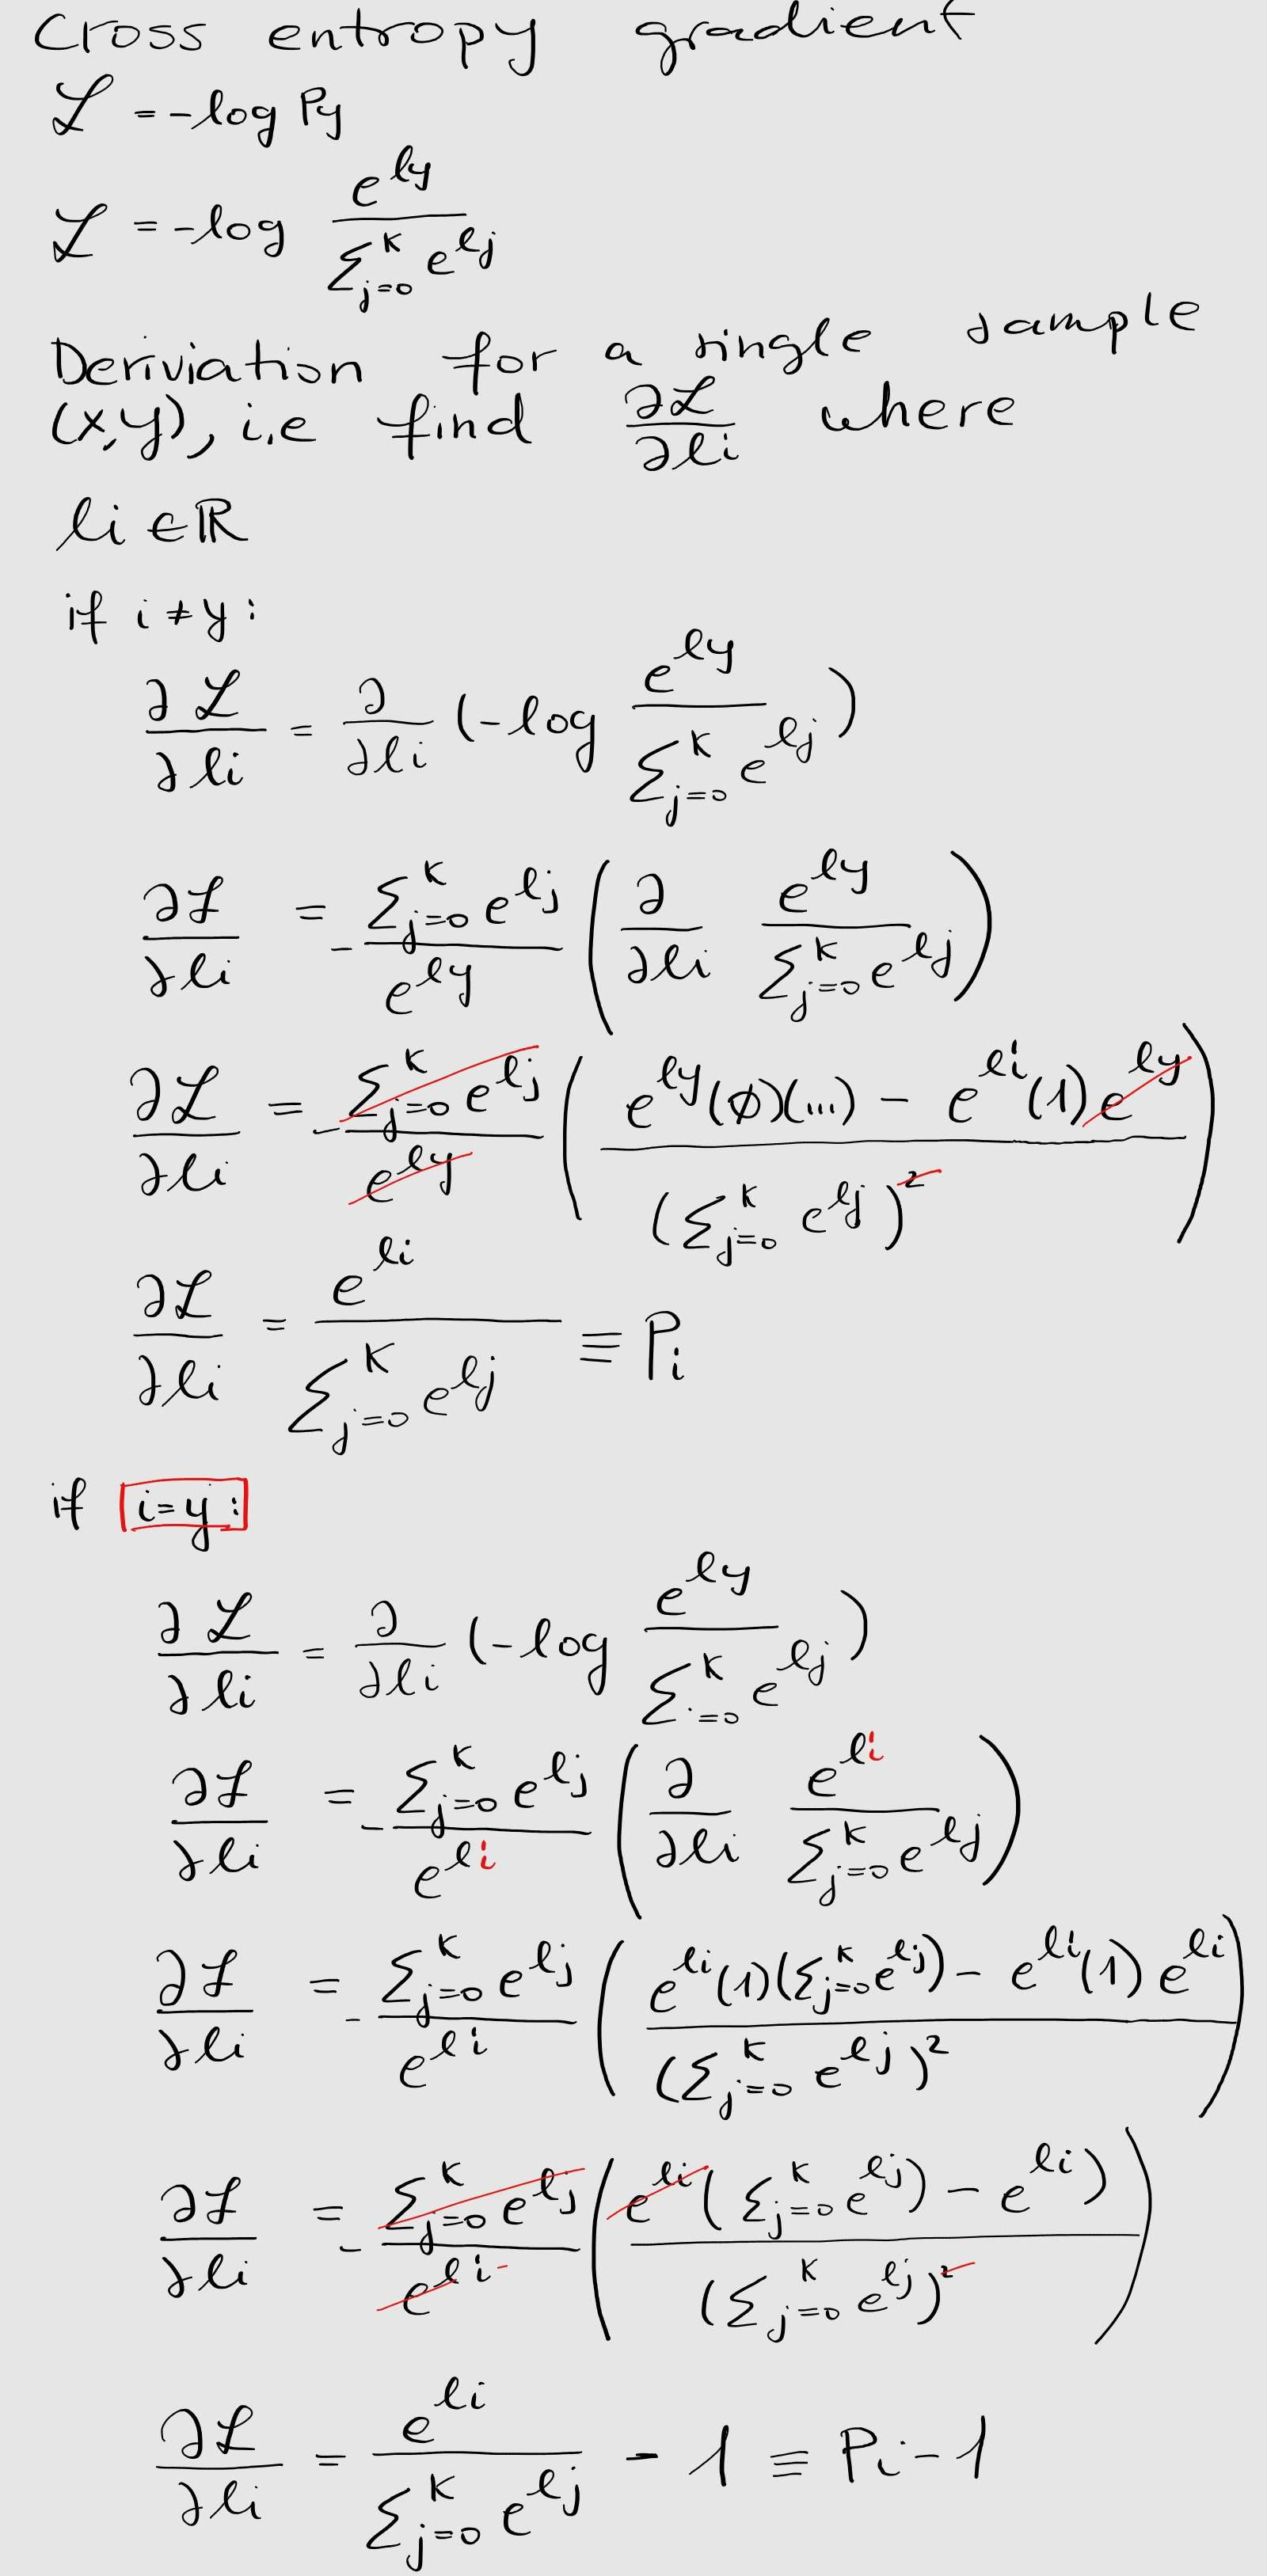

In [ ]:
# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3599724769592285 diff: 4.76837158203125e-07


In [ ]:
# backward pass
prob = logits.exp() / (logits.exp().sum(1, keepdim=True))
prob[range(n), Yb] = prob[range(n), Yb] - 1
dloss_fast = 1 / n
dlogits = prob * dloss_fast

In [ ]:
cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 7.2177499532699585e-09


## 3. *Visualiaze the derivative of logits for a random forward pass, for a good forward pass (where we get lets say 70 % of predictions right) and for a perfect forward pass, what is happening with the derivative of logits and why ?*

**What the derivative of logits represents ?**

Derivative of logits represents a "force" by which we are going to pull down on the probabilities of the incorrect indices and by which are going to pulling up on the correct indicies. The emounth of "force" that we aplly is proportional to the probabilities that we get on the forward pass.


In [ ]:
loss_fast = F.cross_entropy(logits, Yb)
prob = logits.exp() / (logits.exp().sum(1, keepdim=True))
prob[range(n), Yb] = prob[range(n), Yb] - 1
dloss_fast = 1 / n
dlogits = prob * dloss_fast

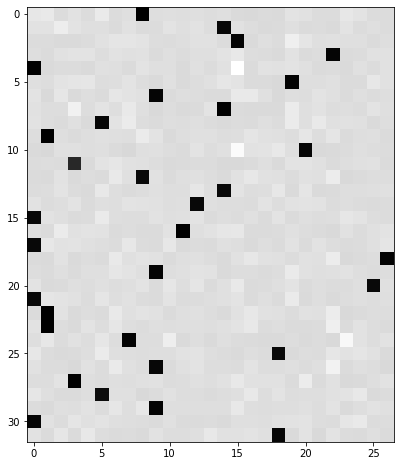

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(
    dlogits.detach(),
    cmap="gray"
)

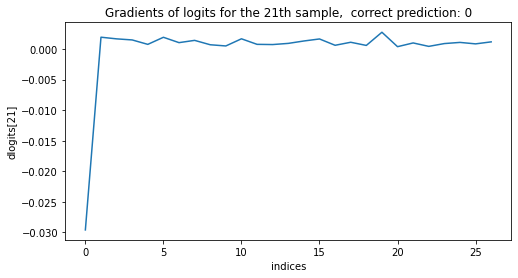

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(dlogits.detach()[21])
plt.xlabel("indices")
plt.ylabel("dlogits[21]")
plt.title(f"Gradients of logits for the 21th sample,  correct prediction: {Yb[21]}");

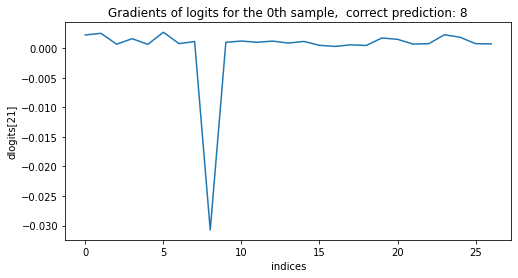

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(dlogits.detach()[0])
plt.xlabel("indices")
plt.ylabel("dlogits[21]")
plt.title(f"Gradients of logits for the 0th sample,  correct prediction: {Yb[0]}");

**Simulate a "good" forward pass**

We see that the gradient of logits is almost zero for correct predictions, but
is relatively high for incorect predictions.

In [ ]:
rand_idx = torch.randperm(n)[:int(n * 0.7)]
logits_good = logits.clone()
logits_good[rand_idx, Yb[rand_idx]] = 20.0
loss_fast_good = F.cross_entropy(logits_good, Yb)
loss_fast_good

tensor(1.0785, grad_fn=<NllLossBackward0>)

In [ ]:
# backward pass
prob_good = F.softmax(logits_good, 1)
prob_good[range(n), Yb] = prob_good[range(n), Yb] - 1
dlogits_good = prob_good * loss_fast_good

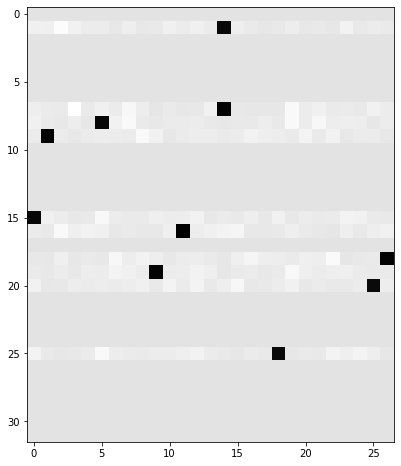

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(
    dlogits_good.detach(),
    cmap="gray"
)

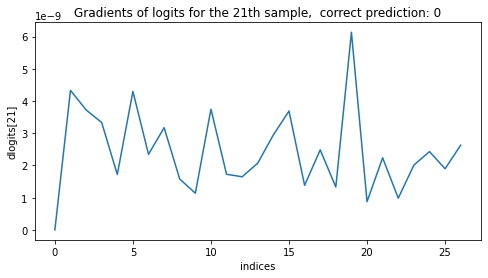

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(dlogits_good.detach()[21])
plt.xlabel("indices")
plt.ylabel("dlogits[21]")
plt.title(f"Gradients of logits for the 21th sample,  correct prediction: {Yb[21]}");

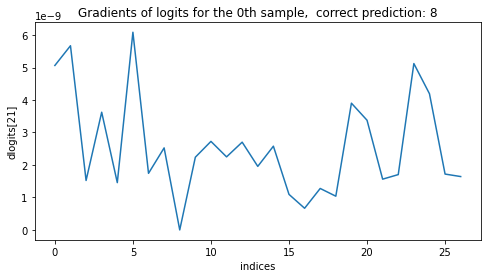

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(dlogits_good.detach()[0])
plt.xlabel("indices")
plt.ylabel("dlogits[21]")
plt.title(f"Gradients of logits for the 0th sample,  correct prediction: {Yb[0]}");

**Simulate the perfect forward pass**


We see that the gradient of logits is zero for all preditions (since all are correct).

In [ ]:
# Simulate the perfect forward pass
logits_perf = torch.zeros_like(logits)
logits_perf[range(n), Yb] = 20.0
loss_fast_perf = F.cross_entropy(logits_perf, Yb)
loss_fast_perf

tensor(0.)

In [ ]:
# backward pass
prob_pref = F.softmax(logits_perf, 1)
prob_pref[range(n), Yb] = prob_pref[range(n), Yb] - 1
dlogits_perf = prob_pref * loss_fast_perf

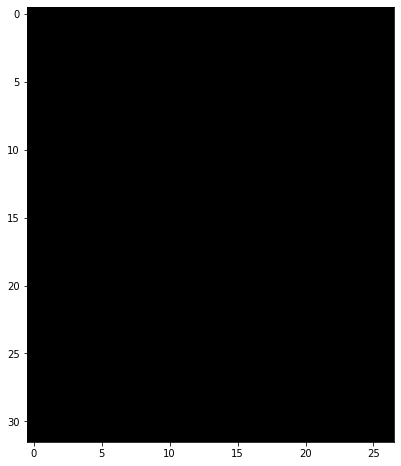

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(
    dlogits_perf.detach(),
    cmap="gray"
)

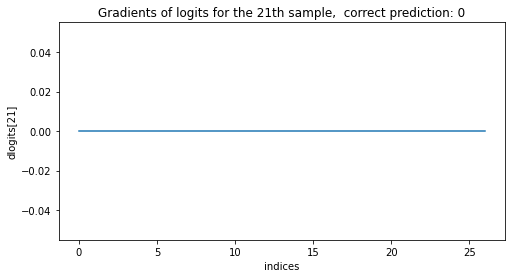

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(dlogits_perf.detach()[21])
plt.xlabel("indices")
plt.ylabel("dlogits[21]")
plt.title(f"Gradients of logits for the 21th sample,  correct prediction: {Yb[21]}");

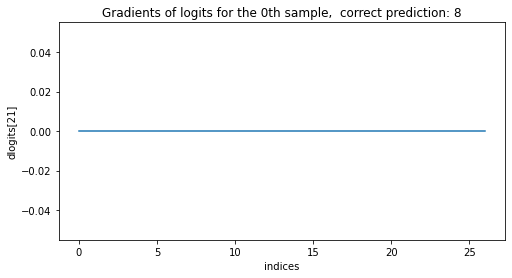

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(dlogits_perf.detach()[0])
plt.xlabel("indices")
plt.ylabel("dlogits[21]")
plt.title(f"Gradients of logits for the 0th sample,  correct prediction: {Yb[0]}");

## 4. *backprop through batchnorm but all in one go, to complete this challenge look at the mathematical expression of the output of batchnorm,+take the derivative w.r.t. its input, simplify the expression, and just write it out, BatchNorm paper: https://arxiv.org/abs/1502.03167*

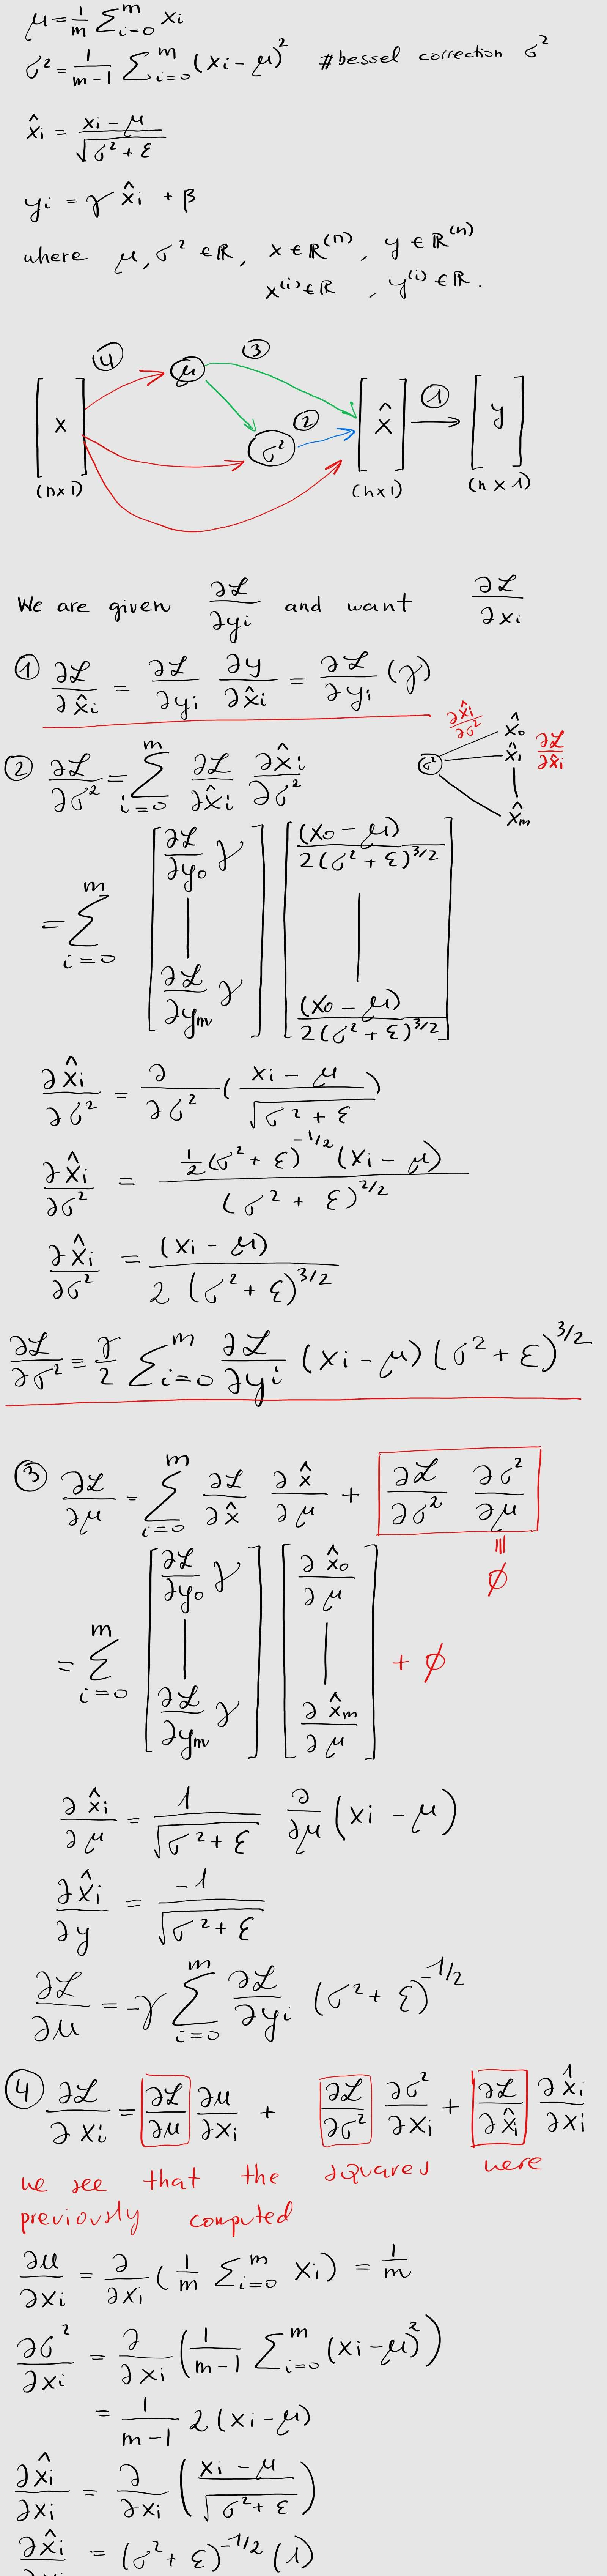

In [ ]:
# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

In [ ]:
cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


## 5. *putting it all together! Train the MLP neural net with your own backward pass*

In [231]:
# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  # loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  dlogits = F.softmax(logits, 1)
  dlogits[range(n), Yb] -= 1
  dlogits /= n
  # 2nd layer backprop
  dh = dlogits @ W2.T
  dW2 = h.T @ dlogits
  db2 = dlogits.sum(0)
  # tanh
  dhpreact = (1.0 - h**2) * dh
  # batchnorm backprop
  dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
  dbnbias = dhpreact.sum(0, keepdim=True)
  dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
  # 1st layer
  dembcat = dhprebn @ W1.T
  dW1 = embcat.T @ dhprebn
  db1 = dhprebn.sum(0)
  # embedding
  demb = dembcat.view(emb.shape)
  dC = torch.zeros_like(C)
  for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
      ix = Xb[k,j]
      dC[ix] += demb[k,j]
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # useful for checking your gradients
  # if i >= 100:
  #   for p,g in zip(parameters, grads):
  #       cmp(str(tuple(p.shape)), g, p)
  #   break

12297
      0/ 200000: 3.8170
  10000/ 200000: 2.1643
  20000/ 200000: 2.4003
  30000/ 200000: 2.4485
  40000/ 200000: 1.9676
  50000/ 200000: 2.3053
  60000/ 200000: 2.3579
  70000/ 200000: 2.0329
  80000/ 200000: 2.2931
  90000/ 200000: 2.1013
 100000/ 200000: 2.0242
 110000/ 200000: 2.3287
 120000/ 200000: 1.9517
 130000/ 200000: 2.4299
 140000/ 200000: 2.3263
 150000/ 200000: 2.1628
 160000/ 200000: 1.8892
 170000/ 200000: 1.8174
 180000/ 200000: 2.0404
 190000/ 200000: 1.8674


**Calibrate the batch norm at the end of training**

i.e compute the global (on the whole training set) mean and variance, recall that is done beacuse we wan't to perform inference on a single sample (at test time), in that case we use the global mean and variance to make a prediction.

In [232]:
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

**evaluate train and val loss**

In [233]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0712697505950928
val 2.1100761890411377


**Sample from the model**

In [236]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
ambril.
khi.
mreigentleenanden.
jazonte.
den.
arci.
aqui.
nellara.
chaily.
kaleigh.
ham.
joce.
quinthorline.
liven.
corterri.
jarisi.
jace.
pirrat.
edde.
